# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
import math
import sys
%matplotlib inline

In [20]:
class hp:
    n = 1000
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0.5)
train_var = [[1,0.6],[0.2,3]]
train_var = np.matmul(train_var, np.transpose(train_var)) # To make sure that the covariance matrix in positive semi-definate

test_mean_1 = np.full(shape=(hp.f), fill_value = 1.2)
test_var_1 = [[1,1.6],[0.6,2]]
test_var_1 = np.matmul(test_var_1, np.transpose(test_var_1))

test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_var_2 = np.matmul(test_var_2, np.transpose(test_var_2))

test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]
test_var_3 = np.matmul(test_var_3, np.transpose(test_var_3))


class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

## Negative Samples

In [21]:
Dataset.train_positive

,0,1
0,-0.571071,0.546393
1,-0.619629,-1.716551
2,1.169908,0.608844
3,-0.923589,-3.667661
4,0.163152,2.586309
5,1.256795,4.597029
6,-0.325970,-1.540602
...,...,...
993,0.195705,4.963422
994,-0.041525,0.612009


Training Data (Normal)

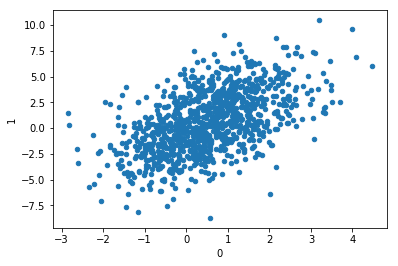

In [22]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

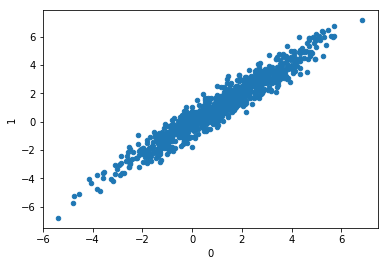

In [23]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

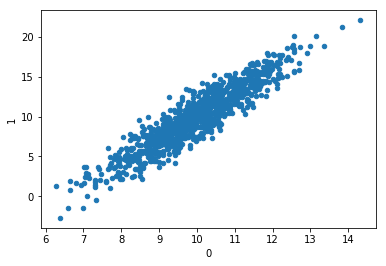

In [24]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

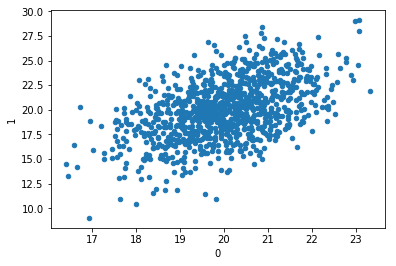

In [25]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

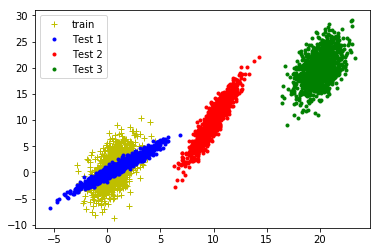

In [26]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y+', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [53]:


class network:
    
    params = {}
    
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [hp.n, hp.f]) #hp.n, hp.f
        
    def get_cost(self, U, Z): #U, Q, Q_, Z
        
        #inverse_regularizer = tf.pow((tf.matmul(Q, Q_) - tf.eye(hp.f)), 2)
        cost = - (-U - tf.log(Z)) #+ tf.reduce_sum(inverse_regularizer)) # get -ve log likelihood
        
        #self.params.update({'U_':tf.reduce_mean(U)}) #, 'ir': tf.reduce_sum(inverse_regularizer)
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        n = hp.n
        f = hp.f
        
        X = self.X
        
        P = tf.Variable(tf.truncated_normal([f]))
        Q_ = tf.Variable(tf.truncated_normal([f])) # [f,f]
        global_step = tf.Variable(0, trainable=False)
        #Q_ = tf.Variable(tf.truncated_normal([f,f]))

        Q = tf.diag(tf.square(Q_)) + tf.eye(f) #tf.matmul(Q_, tf.transpose(Q_)) 
        
        X = tf.layers.dense(X, f)
        X = tf.layers.dense(X, f)
        
        M = P - tf.matmul(X, Q)
        print('M', M.get_shape())
        
        R = tf.matmul(M, Q)
        print('R', R.get_shape())
        
        V = tf.matmul(R, tf.transpose(M))
        print('V', V.get_shape())
        
        U = tf.reduce_sum(V, axis = 1, keepdims = True)
        print('U', U.get_shape())
        
        Q_det = tf.matrix_determinant(Q)
        print('Q_det', Q_det.get_shape())
        
        Z = tf.pow(tf.multiply(tf.pow(2*math.pi,f), Q_det), 1/2)
        print('Z', Z.get_shape())
        
        Y_ = tf.divide(tf.exp(-U/2), Z)
        print("Y_", Y_.get_shape())
        
        loss = self.get_cost(U, Z) # 1- Y_[0]
        
        starter_learning_rate = 0.01
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)
        train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
        
        self.params.update({'U': U, 'P':P, 'Q':Q, 'Z':Z, 'Q_det':Q_det}) #  
        
        return train, loss, Y_, self.params


In [54]:
epochs = 10000
net = network()
loss_arr = []
Dataset.Y_ = []

output_tensors = net.get_optimizer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        X = np.reshape(Dataset.train_positive.values, (hp.n, -1))
        
        #for i in range(X.shape[0]):
        #x = X#[i,:].reshape((1,-1))
        try:
            train, loss, Y_, params = sess.run(output_tensors, feed_dict={net.X:X})
        except tf.errors.InvalidArgumentError as e:
            #print(e)
            pass

        #print("epoch", epoch, "loss", loss)#, 'U', params['U'], 'Z', params['Z']) #, 'IR', params['ir'], 'Z', params['Z'], 'U', params['U']
        loss_arr.append(loss)
            

        if(np.abs(loss) < 0.1):
            break
    Dataset.Y_.append(Y_)
    print('P (Mean)', params['P'], 'Q (Covariance)', params['Q'])

M (1000, 2)
R (1000, 2)
V (1000, 1000)
U (1000, 1)
Q_det ()
Z ()
Y_ (1000, 1)
P (Mean) [-0.42831388  0.45962313] Q (Covariance) [[1. 0.]
 [0. 1.]]


In [37]:
#Dataset.Y_

[array([[0.15915489],
        [0.15915433],
        [0.15915492],
        [0.15915796],
        [0.15915553],
        [0.15915523],
        [0.159156  ],
        [0.1591528 ],
        [0.15915325],
        [0.1591552 ],
        [0.15915523],
        [0.15915458],
        [0.15915433],
        [0.15915386],
        [0.15915394],
        [0.15915614],
        [0.15915325],
        [0.15915516],
        [0.15915462],
        [0.15915371],
        [0.1591547 ],
        [0.15915509],
        [0.15915495],
        [0.15915097],
        [0.1591528 ],
        [0.15915492],
        [0.15915234],
        [0.15915592],
        [0.1591556 ],
        [0.1591528 ],
        [0.1591528 ],
        [0.15915644],
        [0.15915509],
        [0.15915614],
        [0.15915433],
        [0.15915495],
        [0.15915492],
        [0.15915357],
        [0.15915523],
        [0.1591547 ],
        [0.15915614],
        [0.15915523],
        [0.1591534 ],
        [0.15915796],
        [0.15916191],
        [0

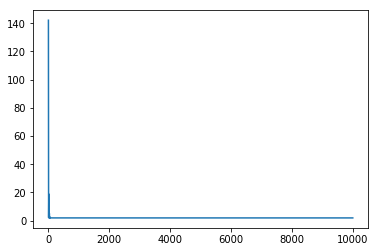

In [55]:
plt.plot(loss_arr)